In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iterative-stratification/iterative-stratification-master/.gitignore
/kaggle/input/iterative-stratification/iterative-stratification-master/LICENSE
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterative-stratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterative-stratification/iterative-stratification-master/README.md
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.py
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/test_ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/__init__.py
/kaggle/input/helper-functions/clr_callback.py
/kaggle/input/helper-functions/learningratefinder.py
/kaggle/input/lish-moa/sample_sub

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/helper-functions')
sys.path.insert(2, '/kaggle/input/iterative-stratification/iterative-stratification-master')

## Import Packages

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils  import plot_model
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

## Helper Functions

In [4]:
def logloss_metric(df, y_true, y_pred):
    
    metrics = []
    
    # Calculate log_loss individually for every field
    for _target in df.columns[1:]:
        metrics.append(log_loss(y_true.loc[:, _target], 
                                y_pred.loc[:, _target].astype(float), 
                                labels=[0,1]))
    
    # Return mean of individual log_loss values
    return np.mean(metrics)

In [5]:
def data_preprocess(train_df, predict_df, target_labels):
    
    # Display individual dataframe shapes
    print("----------- Before Feature Engineering -----------")
    print("train_df: {}".format(train_df.shape))
    print("predict_df: {}".format(predict_df.shape))
    print("target_labels: {}".format(target_labels.shape))
    train_samples = train_df.shape[0]
    
    # Combined both input dataframes
    combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
    
    # Feature Engineering
    target_labels = target_labels.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
    combined_df['cp_type'] = combined_df['cp_type'].apply(lambda x: 0 if x=='trt_cp' else 1 if x=='ctl_vehicle' else -1)
    combined_df['cp_time_days'] = combined_df['cp_time'].apply(lambda x: x//24)
    combined_df['cp_dose'] = combined_df['cp_dose'].apply(lambda x: 0 if x=='D1' else 1 if x=='D2' else -1)
    combined_df.drop(['sig_id'], axis=1, inplace=True)
    target_labels.drop(['sig_id'], axis=1, inplace=True)
    
    # Segregate train and predict datasets
    train_df = combined_df[:train_samples]
    predict_df = combined_df[train_samples:]
    
    # Drop training records with cp_type = 'ctl_vehicle'
    train_df = train_df.loc[train_df['cp_type']==0].reset_index(drop=True)
    
    print("\n----------- After Feature Engineering -----------")
    print("train_df: {}".format(train_df.shape))
    print("predict_df: {}".format(predict_df.shape))
    print("target_labels: {}".format(target_labels.shape))
    
    # Segregate train and predict datasets
    train_x = train_df.values
    train_y = target_labels.values
    predict_x = predict_df.values
    
    print("\n----------- NumPy Array Shapes -----------")
    print("train_x: {}".format(train_x.shape))
    print("train_y: {}".format(train_y.shape))
    print("predict_x: {}".format(predict_x.shape))
    
    return train_x, train_y, predict_x

## Set file paths for train and predict datasets

In [6]:
train_dataset = "/kaggle/input/lish-moa/train_features.csv"
train_labels_scored = "/kaggle/input/lish-moa/train_targets_scored.csv"
train_labels_unscored = "/kaggle/input/lish-moa/train_targets_nonscored.csv"
predict_dataset = "/kaggle/input/lish-moa/test_features.csv"

## Unscored Labels

### Data Preprocessing

#### Process train and predict features datasets

In [7]:
train_df = pd.read_csv(train_dataset)
train_label_unscored_df = pd.read_csv(train_labels_unscored)
predict_df = pd.read_csv(predict_dataset)

print("train_df: {}".format(train_df.shape))
print("train_label_unscored_df: {}".format(train_label_unscored_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (23814, 876)
train_label_unscored_df: (23814, 403)
predict_df: (3982, 876)


In [8]:
train_x, train_y_unscored, predict_x = data_preprocess(train_df, 
                                                       predict_df, 
                                                       train_label_unscored_df)

#scaler = MinMaxScaler().fit(train_x)
#scaler = StandardScaler().fit(train_x)
scaler = RobustScaler().fit(train_x)

train_x = scaler.transform(train_x)
Xpredict = scaler.transform(predict_x)

----------- Before Feature Engineering -----------
train_df: (23814, 876)
predict_df: (3982, 876)
target_labels: (23814, 403)

----------- After Feature Engineering -----------
train_df: (21948, 876)
predict_df: (3982, 876)
target_labels: (21948, 402)

----------- NumPy Array Shapes -----------
train_x: (21948, 876)
train_y: (21948, 402)
predict_x: (3982, 876)


#### Split training data into train/ validation/ test datasets

In [9]:
sss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.085, random_state=10)
for train_index, test_index in sss.split(train_x, train_y_unscored):
    Xtrain, Xtest = train_x[train_index], train_x[test_index]
    Ytrain, Ytest = train_y_unscored[train_index], train_y_unscored[test_index]

In [10]:
Xtrain_DNN = Xtrain.copy()
Xtest_DNN = Xtest.copy()
Xpredict_DNN = Xpredict.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_DNN shape: {}".format(Xtrain_DNN.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_DNN shape: {}".format(Xtest_DNN.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict_DNN shape: {}".format(Xpredict_DNN.shape))

------------------------- Training Dataset -------------------------
Xtrain_DNN shape: (20082, 876)
Ytrain shape: (20082, 402)

------------------------- Test Dataset -------------------------
Xtest_DNN shape: (1866, 876)
Ytest shape: (1866, 402)

------------------------- Prediction Dataset -------------------------
Xpredict_DNN shape: (3982, 876)


In [11]:
Xtrain_CNN = np.expand_dims(Xtrain, axis=2)
Xtest_CNN = np.expand_dims(Xtest, axis=2)
Xpredict_CNN = np.expand_dims(Xpredict, axis=2)

print("------------------------- Training Dataset -------------------------")
print("Xtrain_CNN shape: {}".format(Xtrain_CNN.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_CNN shape: {}".format(Xtest_CNN.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict_CNN shape: {}".format(Xpredict_CNN.shape))

------------------------- Training Dataset -------------------------
Xtrain_CNN shape: (20082, 876, 1)
Ytrain shape: (20082, 402)

------------------------- Test Dataset -------------------------
Xtest_CNN shape: (1866, 876, 1)
Ytest shape: (1866, 402)

------------------------- Prediction Dataset -------------------------
Xpredict_CNN shape: (3982, 876, 1)


### Build the DNN Model

In [12]:
def dnn_model(input_shape):
    
    # Input Layer
    x_input = Input(shape=(input_shape, ), name='INPUT')
    
    # Fully-connected Layer 1
    x = Dense(units=1024, name='FC-1', activation='relu', kernel_regularizer=l2(0.001))(x_input)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)
    
    # Fully-connected Layer 2
    x = Dense(units=1024, name='FC-2', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)

    # Fully-connected Layer 3
    x = Dense(units=512, name='FC-3', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-3')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-3')(x)

    # Fully-connected Layer 4
    x = Dense(units=512, name='FC-4', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-4')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-4')(x)
    
    # Fully-connected Layer 5
    x = Dense(units=256, name='FC-5', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-5')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-5')(x)
    
    # Output Layer
    x = Dense(units=402, activation='sigmoid', name='OUTPUT')(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='DNN_Model_Unscored')

    return model

In [13]:
# Define the model hyperparameters
mini_batch_size = 256
min_lr = 1e-5
max_lr = 3e-3
step_size = 4 * (Xtrain_DNN.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [14]:
# Create the model
model = dnn_model(Xtrain_DNN.shape[1])

# Compile model to configure the learning process
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-3))

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
               mode=clr_method, step_size=step_size)

In [15]:
model.summary()

Model: "DNN_Model_Unscored"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 876)]             0         
_________________________________________________________________
FC-1 (Dense)                 (None, 1024)              898048    
_________________________________________________________________
BN_FC-1 (BatchNormalization) (None, 1024)              4096      
_________________________________________________________________
DROPOUT_FC-1 (Dropout)       (None, 1024)              0         
_________________________________________________________________
FC-2 (Dense)                 (None, 1024)              1049600   
_________________________________________________________________
BN_FC-2 (BatchNormalization) (None, 1024)              4096      
_________________________________________________________________
DROPOUT_FC-2 (Dropout)       (None, 1024)       

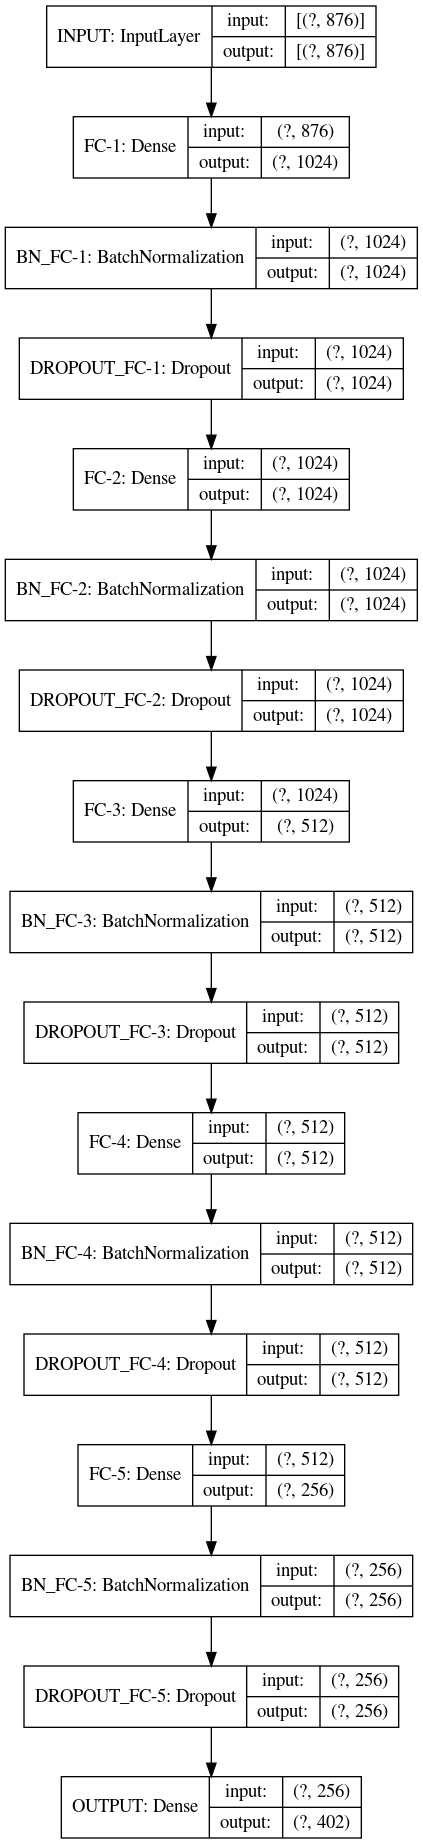

In [16]:
plot_model(model, to_file='/kaggle/working/unscored_labels_model_plot_dnn.png', show_shapes=True, show_layer_names=True)

In [17]:
'''
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain_DNN, Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain_DNN) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()
'''

'\n# Learning Rate Finder\nlrf = LearningRateFinder(model)\nlrf.find((Xtrain_DNN, Ytrain),\n         startLR=1e-10, endLR=1e-1,\n         stepsPerEpoch=np.ceil((len(Xtrain_DNN) / float(mini_batch_size))),\n         batchSize=mini_batch_size)\nlrf.plot_loss()\nplt.grid()\nplt.show()\n'

In [18]:
# Define K-fold cross validation test harness
kfold = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=10)
y_pred_dnn = 0
y_pred_dnn_final = 0
idx = 0

for train, val in kfold.split(Xtrain_DNN, Ytrain):
    idx += 1
    print("---------------- Fold {} ----------------".format(idx))
    
    train_x, train_y = Xtrain_DNN[train], Ytrain[train]
    val_x, val_y = Xtrain_DNN[val], Ytrain[val]
    
    # Create the model
    model = dnn_model(Xtrain_DNN.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=1e-3))

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
                   mode=clr_method, step_size=step_size)
    
    # Fit the model
    history = model.fit(x=train_x, y=train_y, batch_size=mini_batch_size,
                        epochs=125, verbose=1,
                        callbacks=[clr], workers=5,
                        validation_data=(val_x, val_y))
    
    # Make predictions
    pred = model.predict(Xtest_DNN)
    y_pred_dnn += pred
    
    pred_final = model.predict(Xpredict_DNN)
    y_pred_dnn_final += pred_final

y_pred_dnn /= float(idx)
y_pred_dnn_final /= float(idx)

---------------- Fold 1 ----------------
Epoch 1/125
68/68 [==============================] - 1s 13ms/step - loss: 3.8004 - val_loss: 2.7300
Epoch 2/125
68/68 [==============================] - 1s 8ms/step - loss: 1.6057 - val_loss: 0.5868
Epoch 3/125
68/68 [==============================] - 1s 8ms/step - loss: 0.3100 - val_loss: 0.1912
Epoch 4/125
68/68 [==============================] - 1s 8ms/step - loss: 0.1606 - val_loss: 0.1823
Epoch 5/125
68/68 [==============================] - 1s 9ms/step - loss: 0.1546 - val_loss: 0.1115
Epoch 6/125
68/68 [==============================] - 1s 9ms/step - loss: 0.1679 - val_loss: 0.1747
Epoch 7/125
68/68 [==============================] - 1s 9ms/step - loss: 0.0839 - val_loss: 0.0418
Epoch 8/125
68/68 [==============================] - 1s 9ms/step - loss: 0.0311 - val_loss: 0.0359
Epoch 9/125
68/68 [==============================] - 1s 8ms/step - loss: 0.0518 - val_loss: 0.0488
Epoch 10/125
68/68 [==============================] - 1s 12ms/step 

#### Validate the model

In [19]:
# Before applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_unscored_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_dnn, columns=train_label_unscored_df.columns[1:])
logloss_metric(train_label_unscored_df, true_labels, pred_labels)

0.00553488478179198

In [20]:
# After applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_unscored_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_dnn, columns=train_label_unscored_df.columns[1:])
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', predict_df.columns] = 0
logloss_metric(train_label_unscored_df, true_labels, pred_labels)

0.00553488478179198

### Build the CNN model

In [21]:
def cnn_model(input_shape):
    
    # Input Layer
    x_input = Input(shape=(input_shape, 1), name='INPUT')

    # Convolutional Layers
    x = Conv1D(filters=16, kernel_size=5, strides=2, padding='valid', 
               activation='relu', name='CONV-1', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.0001))(x_input)
    x = BatchNormalization(name='BN_CONV-1')(x)
    x = MaxPool1D(pool_size=2, name='MAXPOOL-1')(x)
    x = Dropout(rate=0.25, name='DROPOUT_CONV-1')(x)

    x = Conv1D(filters=32, kernel_size=5, strides=2, padding='same', 
               activation='relu', name='CONV-2', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_CONV-2')(x)
    x = MaxPool1D(pool_size=2, name='MAXPOOL-2')(x)
    x = Dropout(rate=0.25, name='DROPOUT_CONV-2')(x)

    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
               activation='relu', name='CONV-3', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_CONV-3')(x)
    x = MaxPool1D(pool_size=2, name='MAXPOOL-3')(x)
    x = Dropout(rate=0.25, name='DROPOUT_CONV-3')(x)
    
    # Fully-connected Layers
    x = Flatten(name='FLATTEN')(x)
    x = Dense(units=1024, name='FC-1', activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)
    
    x = Dense(units=512, name='FC-2', activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)

    x = Dense(units=512, name='FC-3', activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-3')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-3')(x)

    x = Dense(units=256, name='FC-4', activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-4')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-4')(x)
    
    # Output Layer
    x = Dense(units=402, activation='sigmoid', name='OUTPUT')(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='CNN_Model_Unscored')

    return model

In [22]:
# Define the model hyperparameters
mini_batch_size = 256
min_lr = 1e-4
max_lr = 1e-2
step_size = 4 * (Xtrain_CNN.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [23]:
# Create the model
model = cnn_model(Xtrain_CNN.shape[1])

# Compile model to configure the learning process
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-3))

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
               mode=clr_method, step_size=step_size)

In [24]:
model.summary()

Model: "CNN_Model_Unscored"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 876, 1)]          0         
_________________________________________________________________
CONV-1 (Conv1D)              (None, 436, 16)           96        
_________________________________________________________________
BN_CONV-1 (BatchNormalizatio (None, 436, 16)           64        
_________________________________________________________________
MAXPOOL-1 (MaxPooling1D)     (None, 218, 16)           0         
_________________________________________________________________
DROPOUT_CONV-1 (Dropout)     (None, 218, 16)           0         
_________________________________________________________________
CONV-2 (Conv1D)              (None, 109, 32)           2592      
_________________________________________________________________
BN_CONV-2 (BatchNormalizatio (None, 109, 32)    

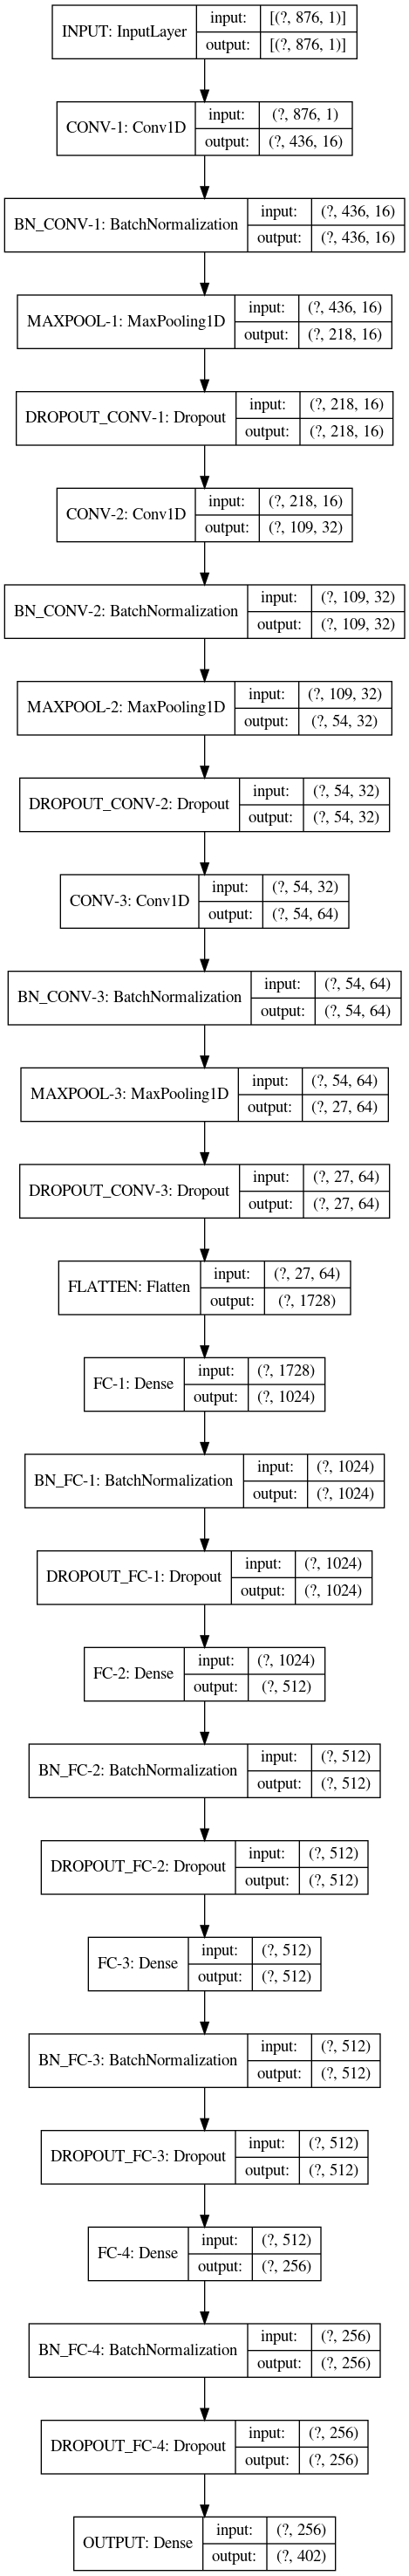

In [25]:
plot_model(model, to_file='/kaggle/working/unscored_labels_model_plot_cnn.png', show_shapes=True, show_layer_names=True)

In [26]:
'''
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain_CNN, Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain_CNN) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()
'''

'\n# Learning Rate Finder\nlrf = LearningRateFinder(model)\nlrf.find((Xtrain_CNN, Ytrain),\n         startLR=1e-10, endLR=1e-1,\n         stepsPerEpoch=np.ceil((len(Xtrain_CNN) / float(mini_batch_size))),\n         batchSize=mini_batch_size)\nlrf.plot_loss()\nplt.grid()\nplt.show()\n'

In [27]:
# Define K-fold cross validation test harness
kfold = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=10)
y_pred_cnn = 0
y_pred_cnn_final = 0
idx = 0

for train, val in kfold.split(Xtrain_CNN, Ytrain):
    idx += 1
    print("---------------- Fold {} ----------------".format(idx))
    
    train_x, train_y = Xtrain_CNN[train], Ytrain[train]
    val_x, val_y = Xtrain_CNN[val], Ytrain[val]
    
    # Create the model
    model = cnn_model(Xtrain_CNN.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=1e-3))

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
                   mode=clr_method, step_size=step_size)
    
    # Fit the model
    history = model.fit(x=train_x, y=train_y, batch_size=mini_batch_size,
                        epochs=125, verbose=1,
                        callbacks=[clr], workers=5,
                        validation_data=(val_x, val_y))
    
    # Make predictions
    pred = model.predict(Xtest_CNN)
    y_pred_cnn += pred
    
    pred_final = model.predict(Xpredict_CNN)
    y_pred_cnn_final += pred_final

y_pred_cnn /= float(idx)
y_pred_cnn_final /= float(idx)

---------------- Fold 1 ----------------
Epoch 1/125
68/68 [==============================] - 1s 19ms/step - loss: 1.1640 - val_loss: 0.7211
Epoch 2/125
68/68 [==============================] - 1s 12ms/step - loss: 0.3521 - val_loss: 0.1648
Epoch 3/125
68/68 [==============================] - 1s 14ms/step - loss: 0.1141 - val_loss: 0.0734
Epoch 4/125
68/68 [==============================] - 1s 17ms/step - loss: 0.0412 - val_loss: 1.6100
Epoch 5/125
68/68 [==============================] - 1s 14ms/step - loss: 0.5632 - val_loss: 0.2474
Epoch 6/125
68/68 [==============================] - 1s 14ms/step - loss: 0.1430 - val_loss: 0.0844
Epoch 7/125
68/68 [==============================] - 1s 12ms/step - loss: 0.0644 - val_loss: 0.0481
Epoch 8/125
68/68 [==============================] - 1s 14ms/step - loss: 0.0414 - val_loss: 0.0357
Epoch 9/125
68/68 [==============================] - 1s 13ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 10/125
68/68 [==============================] - 1s 12

#### Validate the model

In [28]:
# Before applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_unscored_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_cnn, columns=train_label_unscored_df.columns[1:])
logloss_metric(train_label_unscored_df, true_labels, pred_labels)

0.0051467310411944245

In [29]:
# After applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_unscored_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_cnn, columns=train_label_unscored_df.columns[1:])
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', predict_df.columns] = 0
logloss_metric(train_label_unscored_df, true_labels, pred_labels)

0.0051467310411944245

In [30]:
y_pred_test = (y_pred_dnn + y_pred_cnn)/2

In [31]:
# Before applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_unscored_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_test, columns=train_label_unscored_df.columns[1:])
logloss_metric(train_label_unscored_df, true_labels, pred_labels)

0.005242887062511472

In [32]:
# After applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_unscored_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_test, columns=train_label_unscored_df.columns[1:])
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', predict_df.columns] = 0
logloss_metric(train_label_unscored_df, true_labels, pred_labels)

0.005242887062511472

### Combined prediction of both models

In [33]:
y_pred_final = (y_pred_dnn_final + y_pred_cnn_final)/2
y_pred_final = (y_pred_final >= 0.5).astype(int)
print(y_pred_final.shape)

(3982, 402)


## Scored Labels

### Data Preprocessing

#### Process train and predict features datasets

In [34]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
train_label_unscored_df = pd.read_csv(train_labels_unscored)
train_label_df = pd.read_csv(train_labels_scored)

print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))
print("train_label_unscored_df: {}".format(train_label_unscored_df.shape))
print("train_label_df: {}".format(train_label_df.shape))

train_df: (23814, 876)
predict_df: (3982, 876)
train_label_unscored_df: (23814, 403)
train_label_df: (23814, 207)


In [35]:
train_df = pd.merge(train_df, train_label_unscored_df, 
                    how='inner', on='sig_id')
print("train_df: {}".format(train_df.shape))
train_df.head()

train_df: (23814, 1278)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,0


In [36]:
pred_labels_unscored_df = pd.DataFrame(y_pred_final, columns=train_label_unscored_df.columns[1:])
pred_labels_unscored_df['sig_id'] = predict_df['sig_id']
pred_labels_unscored_df.loc[predict_df['cp_type']=='ctl_vehicle', train_label_unscored_df.columns] = 0
pred_labels_unscored_df.head()

,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,...,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor,sig_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_0004d9e33
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_001897cda
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_00276f245
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_0027f1083


In [37]:
predict_df = pd.merge(predict_df, pred_labels_unscored_df, 
                      how='inner', on='sig_id')
print("predict_df: {}".format(predict_df.shape))
predict_df.head()

predict_df: (3624, 1278)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0,0,0,0,0,0,0,0,0,0
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0,0,0,0,0,0,0,0,0,0
2,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0,0,0,0,0,0,0,0,0,0
3,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0,0,0,0,0,0,0,0,0,0
4,id_006fc47b8,trt_cp,48,D2,0.3658,0.5536,-0.6898,-1.6270,0.5239,-0.3832,...,0,0,0,0,0,0,0,0,0,0


In [38]:
train_x, train_y, predict_x = data_preprocess(train_df, 
                                     predict_df, 
                                     train_label_df)

#scaler = MinMaxScaler().fit(train_x)
#scaler = StandardScaler().fit(train_x)
scaler = RobustScaler().fit(train_x)

train_x = scaler.transform(train_x)
Xpredict = scaler.transform(predict_x)

----------- Before Feature Engineering -----------
train_df: (23814, 1278)
predict_df: (3624, 1278)
target_labels: (23814, 207)

----------- After Feature Engineering -----------
train_df: (21948, 1278)
predict_df: (3624, 1278)
target_labels: (21948, 206)

----------- NumPy Array Shapes -----------
train_x: (21948, 1278)
train_y: (21948, 206)
predict_x: (3624, 1278)


#### Split training data into train/ validation/ test datasets

In [39]:
sss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=10)
for train_index, test_index in sss.split(train_x, train_y):
    Xtrain, Xtest = train_x[train_index], train_x[test_index]
    Ytrain, Ytest = train_y[train_index], train_y[test_index]

In [40]:
Xtrain_DNN = Xtrain.copy()
Xtest_DNN = Xtest.copy()
Xpredict_DNN = Xpredict.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_DNN shape: {}".format(Xtrain_DNN.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_DNN shape: {}".format(Xtest_DNN.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict_DNN shape: {}".format(Xpredict_DNN.shape))

------------------------- Training Dataset -------------------------
Xtrain_DNN shape: (19753, 1278)
Ytrain shape: (19753, 206)

------------------------- Test Dataset -------------------------
Xtest_DNN shape: (2195, 1278)
Ytest shape: (2195, 206)

------------------------- Prediction Dataset -------------------------
Xpredict_DNN shape: (3624, 1278)


In [41]:
Xtrain_CNN = np.expand_dims(Xtrain, axis=2)
Xtest_CNN = np.expand_dims(Xtest, axis=2)
Xpredict_CNN = np.expand_dims(Xpredict, axis=2)

print("------------------------- Training Dataset -------------------------")
print("Xtrain_CNN shape: {}".format(Xtrain_CNN.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_CNN shape: {}".format(Xtest_CNN.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict_CNN shape: {}".format(Xpredict_CNN.shape))

------------------------- Training Dataset -------------------------
Xtrain_CNN shape: (19753, 1278, 1)
Ytrain shape: (19753, 206)

------------------------- Test Dataset -------------------------
Xtest_CNN shape: (2195, 1278, 1)
Ytest shape: (2195, 206)

------------------------- Prediction Dataset -------------------------
Xpredict_CNN shape: (3624, 1278, 1)


### Build the DNN Model

In [42]:
def dnn_model(input_shape):
    
    # Input Layer
    x_input = Input(shape=(input_shape, ), name='INPUT')
    
    # Fully-connected Layer 1
    x = Dense(units=1024, name='FC-1', activation='relu', kernel_regularizer=l2(0.001))(x_input)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)
    
    # Fully-connected Layer 2
    x = Dense(units=512, name='FC-2', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)

    # Fully-connected Layer 3
    x = Dense(units=512, name='FC-3', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-3')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-3')(x)

    # Fully-connected Layer 4
    x = Dense(units=512, name='FC-4', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-4')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-4')(x)
    
    # Fully-connected Layer 5
    x = Dense(units=256, name='FC-5', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-5')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-5')(x)
    
    # Fully-connected Layer 6
    x = Dense(units=256, name='FC-6', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='BN_FC-6')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-6')(x)
    
    # Output Layer
    x = Dense(units=206, activation='sigmoid', name='OUTPUT')(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='DNN_Model')

    return model

In [43]:
# Define the model hyperparameters
mini_batch_size = 256
min_lr = 1e-5
max_lr = 8e-3
step_size = 4 * (Xtrain_DNN.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [44]:
# Create the model
model = dnn_model(Xtrain_DNN.shape[1])

# Compile model to configure the learning process
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-3))

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
               mode=clr_method, step_size=step_size)

In [45]:
model.summary()

Model: "DNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 1278)]            0         
_________________________________________________________________
FC-1 (Dense)                 (None, 1024)              1309696   
_________________________________________________________________
BN_FC-1 (BatchNormalization) (None, 1024)              4096      
_________________________________________________________________
DROPOUT_FC-1 (Dropout)       (None, 1024)              0         
_________________________________________________________________
FC-2 (Dense)                 (None, 512)               524800    
_________________________________________________________________
BN_FC-2 (BatchNormalization) (None, 512)               2048      
_________________________________________________________________
DROPOUT_FC-2 (Dropout)       (None, 512)               0 

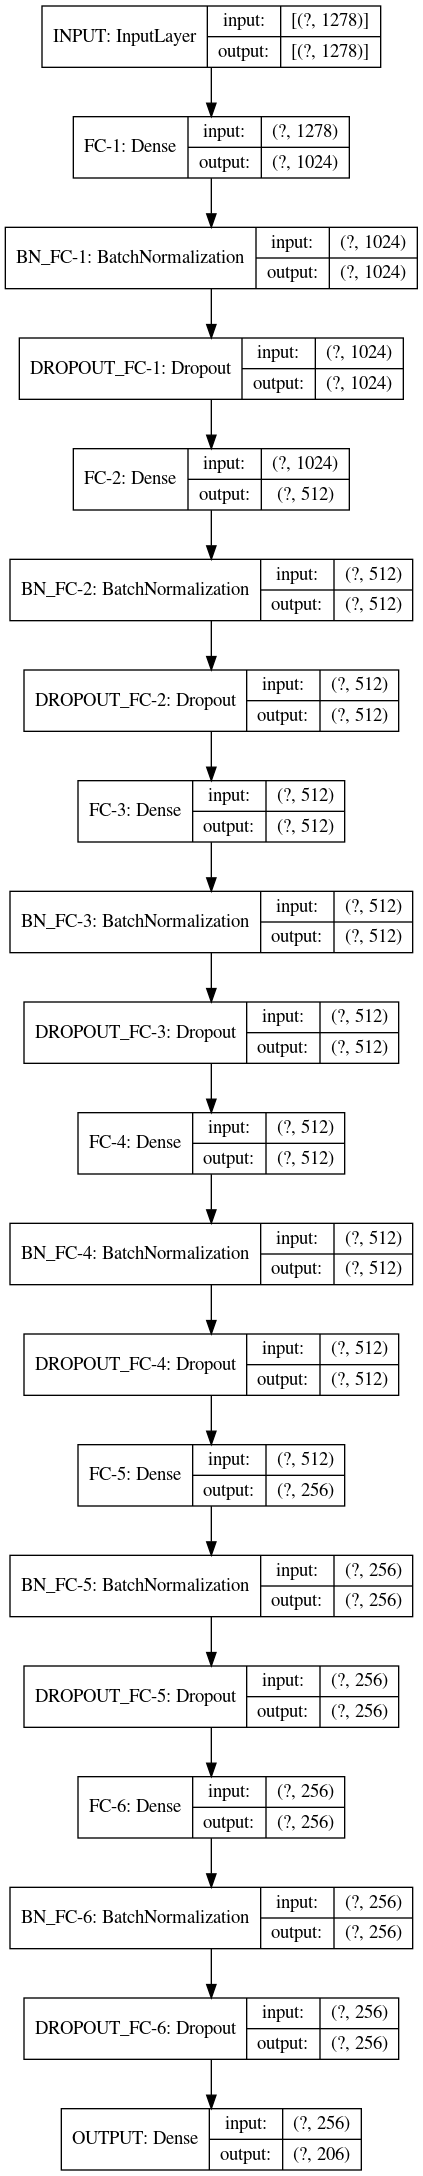

In [46]:
plot_model(model, to_file='/kaggle/working/scored_labels_model_plot_dnn.png', show_shapes=True, show_layer_names=True)

In [47]:
'''
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain_DNN, Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain_DNN) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()
'''

'\n# Learning Rate Finder\nlrf = LearningRateFinder(model)\nlrf.find((Xtrain_DNN, Ytrain),\n         startLR=1e-10, endLR=1e-1,\n         stepsPerEpoch=np.ceil((len(Xtrain_DNN) / float(mini_batch_size))),\n         batchSize=mini_batch_size)\nlrf.plot_loss()\nplt.grid()\nplt.show()\n'

In [48]:
# Define K-fold cross validation test harness
kfold = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=10)
y_pred_dnn = 0
y_pred_dnn_final = 0
idx = 0

for train, val in kfold.split(Xtrain_DNN, Ytrain):
    idx += 1
    print("---------------- Fold {} ----------------".format(idx))
    
    train_x, train_y = Xtrain_DNN[train], Ytrain[train]
    val_x, val_y = Xtrain_DNN[val], Ytrain[val]
    
    # Create the model
    model = dnn_model(Xtrain_DNN.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=1e-3))

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
                   mode=clr_method, step_size=step_size)
    
    # Fit the model
    history = model.fit(x=train_x, y=train_y, batch_size=mini_batch_size,
                        epochs=125, verbose=1,
                        callbacks=[clr], workers=5,
                        validation_data=(val_x, val_y))
    
    # Make predictions
    pred = model.predict(Xtest_DNN)
    y_pred_dnn += pred
    
    pred_final = model.predict(Xpredict_DNN)
    y_pred_dnn_final += pred_final

y_pred_dnn /= float(idx)
y_pred_dnn_final /= float(idx)

---------------- Fold 1 ----------------
Epoch 1/125
67/67 [==============================] - 1s 14ms/step - loss: 3.4333 - val_loss: 1.9092
Epoch 2/125
67/67 [==============================] - 1s 9ms/step - loss: 0.7592 - val_loss: 0.2688
Epoch 3/125
67/67 [==============================] - 1s 9ms/step - loss: 0.1702 - val_loss: 0.4391
Epoch 4/125
67/67 [==============================] - 1s 9ms/step - loss: 0.2356 - val_loss: 0.2989
Epoch 5/125
67/67 [==============================] - 1s 10ms/step - loss: 0.1842 - val_loss: 0.0806
Epoch 6/125
67/67 [==============================] - 1s 9ms/step - loss: 0.3030 - val_loss: 0.1449
Epoch 7/125
67/67 [==============================] - 1s 12ms/step - loss: 0.0911 - val_loss: 0.0560
Epoch 8/125
67/67 [==============================] - 1s 9ms/step - loss: 0.0515 - val_loss: 0.0385
Epoch 9/125
67/67 [==============================] - 1s 9ms/step - loss: 0.0366 - val_loss: 0.0331
Epoch 10/125
67/67 [==============================] - 1s 12ms/ste

#### Validate the model

In [49]:
# Before applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_dnn, columns=train_label_df.columns[1:])
logloss_metric(train_label_df, true_labels, pred_labels)

0.01768033821737428

In [50]:
# After applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_dnn, columns=train_label_df.columns[1:])
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', predict_df.columns] = 0
logloss_metric(train_label_df, true_labels, pred_labels)

0.01768033821737428

#### Learning Curves

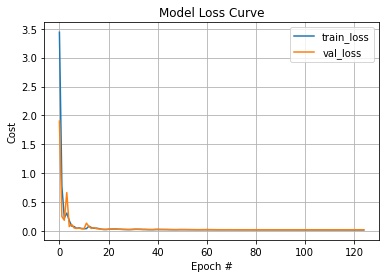

In [51]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

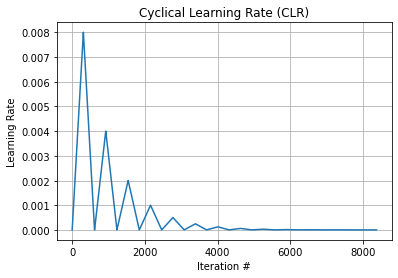

In [52]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

### Build the CNN model

In [53]:
def cnn_model(input_shape):
    
    # Input Layer
    x_input = Input(shape=(input_shape, 1), name='INPUT')

    # Convolutional Layers
    x = Conv1D(filters=16, kernel_size=5, strides=2, padding='valid', 
               activation='relu', name='CONV-1', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.0001))(x_input)
    x = BatchNormalization(name='BN_CONV-1')(x)
    x = MaxPool1D(pool_size=2, name='MAXPOOL-1')(x)
    x = Dropout(rate=0.25, name='DROPOUT_CONV-1')(x)

    x = Conv1D(filters=32, kernel_size=5, strides=2, padding='same', 
               activation='relu', name='CONV-2', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_CONV-2')(x)
    x = MaxPool1D(pool_size=2, name='MAXPOOL-2')(x)
    x = Dropout(rate=0.25, name='DROPOUT_CONV-2')(x)

    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
               activation='relu', name='CONV-3', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_CONV-3')(x)
    x = MaxPool1D(pool_size=2, name='MAXPOOL-3')(x)
    x = Dropout(rate=0.25, name='DROPOUT_CONV-3')(x)
    
    # Fully-connected Layers
    x = Flatten(name='FLATTEN')(x)
    x = Dense(units=1024, name='FC-1', activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)
    
    x = Dense(units=1024, name='FC-2', activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)

    x = Dense(units=256, name='FC-3', activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-3')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-3')(x)

    x = Dense(units=256, name='FC-4', activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-4')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-4')(x)
    
    # Output Layer
    x = Dense(units=206, activation='sigmoid', name='OUTPUT')(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='CNN_Model')

    return model

In [54]:
# Define the model hyperparameters
mini_batch_size = 256
min_lr = 1e-5
max_lr = 1e-2
step_size = 4 * (Xtrain_CNN.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [55]:
# Create the model
model = cnn_model(Xtrain_CNN.shape[1])

# Compile model to configure the learning process
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-3))

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
               mode=clr_method, step_size=step_size)

In [56]:
model.summary()

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 1278, 1)]         0         
_________________________________________________________________
CONV-1 (Conv1D)              (None, 637, 16)           96        
_________________________________________________________________
BN_CONV-1 (BatchNormalizatio (None, 637, 16)           64        
_________________________________________________________________
MAXPOOL-1 (MaxPooling1D)     (None, 318, 16)           0         
_________________________________________________________________
DROPOUT_CONV-1 (Dropout)     (None, 318, 16)           0         
_________________________________________________________________
CONV-2 (Conv1D)              (None, 159, 32)           2592      
_________________________________________________________________
BN_CONV-2 (BatchNormalizatio (None, 159, 32)           12

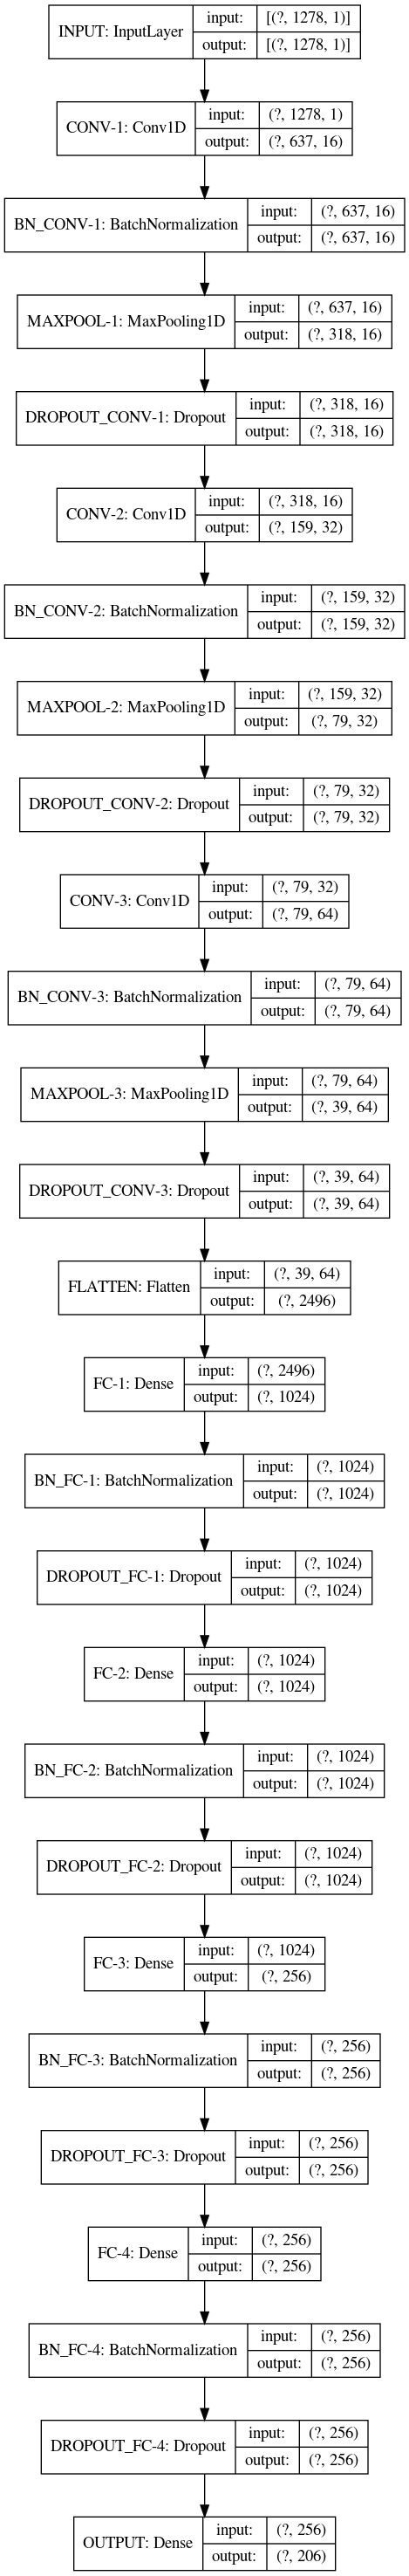

In [57]:
plot_model(model, to_file='/kaggle/working/scored_labels_model_plot_cnn.png', show_shapes=True, show_layer_names=True)

In [58]:
'''
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain_CNN, Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain_CNN) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()
'''

'\n# Learning Rate Finder\nlrf = LearningRateFinder(model)\nlrf.find((Xtrain_CNN, Ytrain),\n         startLR=1e-10, endLR=1e-1,\n         stepsPerEpoch=np.ceil((len(Xtrain_CNN) / float(mini_batch_size))),\n         batchSize=mini_batch_size)\nlrf.plot_loss()\nplt.grid()\nplt.show()\n'

In [59]:
# Define K-fold cross validation test harness
kfold = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=10)
y_pred_cnn = 0
y_pred_cnn_final = 0
idx = 0

for train, val in kfold.split(Xtrain_CNN, Ytrain):
    idx += 1
    print("---------------- Fold {} ----------------".format(idx))
    
    train_x, train_y = Xtrain_CNN[train], Ytrain[train]
    val_x, val_y = Xtrain_CNN[val], Ytrain[val]
    
    # Create the model
    model = cnn_model(Xtrain_CNN.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=1e-3))

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
                   mode=clr_method, step_size=step_size)
    
    # Fit the model
    history = model.fit(x=train_x, y=train_y, batch_size=mini_batch_size,
                        epochs=125, verbose=1,
                        callbacks=[clr], workers=5,
                        validation_data=(val_x, val_y))
    
    # Make predictions
    pred = model.predict(Xtest_CNN)
    y_pred_cnn += pred
    
    pred_final = model.predict(Xpredict_CNN)
    y_pred_cnn_final += pred_final

y_pred_cnn /= float(idx)
y_pred_cnn_final /= float(idx)

---------------- Fold 1 ----------------
Epoch 1/125
67/67 [==============================] - 1s 20ms/step - loss: 1.2706 - val_loss: 0.8669
Epoch 2/125
67/67 [==============================] - 1s 15ms/step - loss: 0.4610 - val_loss: 0.2324
Epoch 3/125
67/67 [==============================] - 1s 14ms/step - loss: 0.1446 - val_loss: 0.0817
Epoch 4/125
67/67 [==============================] - 1s 18ms/step - loss: 0.1086 - val_loss: 0.1877
Epoch 5/125
67/67 [==============================] - 1s 14ms/step - loss: 0.1040 - val_loss: 0.0524
Epoch 6/125
67/67 [==============================] - 1s 15ms/step - loss: 0.0441 - val_loss: 0.0410
Epoch 7/125
67/67 [==============================] - 1s 16ms/step - loss: 0.0365 - val_loss: 0.0334
Epoch 8/125
67/67 [==============================] - 1s 16ms/step - loss: 0.0405 - val_loss: 0.0762
Epoch 9/125
67/67 [==============================] - 1s 15ms/step - loss: 0.0714 - val_loss: 0.0614
Epoch 10/125
67/67 [==============================] - 1s 15

#### Validate the model

In [60]:
# Before applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_cnn, columns=train_label_df.columns[1:])
logloss_metric(train_label_df, true_labels, pred_labels)

0.017500773224299083

In [61]:
# After applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_cnn, columns=train_label_df.columns[1:])
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', predict_df.columns] = 0
logloss_metric(train_label_df, true_labels, pred_labels)

0.017500773224299083

In [62]:
y_pred_test = (y_pred_dnn + y_pred_cnn)/2

In [63]:
# Before applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_test, columns=train_label_df.columns[1:])
logloss_metric(train_label_df, true_labels, pred_labels)

0.017391219892498297

In [64]:
# After applying correction
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns[1:])
pred_labels = pd.DataFrame(y_pred_test, columns=train_label_df.columns[1:])
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', predict_df.columns] = 0
logloss_metric(train_label_df, true_labels, pred_labels)

0.017391219892498297

#### Learning Curves

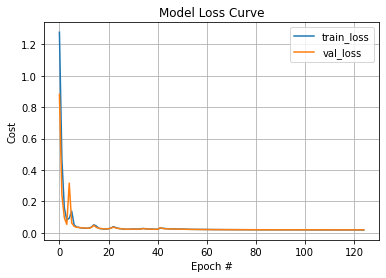

In [65]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

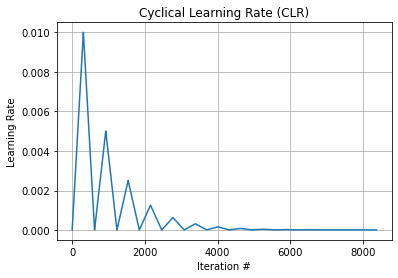

In [66]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

## Create submission file

In [67]:
y_pred = (y_pred_dnn_final + y_pred_cnn_final)/2

pred_labels = pd.DataFrame(y_pred, columns=train_label_df.columns[1:])
pred_labels.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0.000990,0.000918,0.000916,0.013667,0.026315,0.005174,0.003703,0.005074,0.000351,0.018137,...,0.000201,0.000463,0.002566,0.001347,0.000990,0.000205,0.000835,0.001205,0.001802,0.001383
1,0.000815,0.000955,0.002522,0.006330,0.005657,0.002432,0.001965,0.006472,0.001656,0.009994,...,0.000578,0.002468,0.002901,0.002137,0.010965,0.000604,0.013986,0.001843,0.003029,0.002130
2,0.000799,0.000790,0.001462,0.008050,0.011197,0.003120,0.002467,0.005452,0.000648,0.012224,...,0.000304,0.000968,0.002480,0.002455,0.003515,0.000295,0.003439,0.001308,0.002121,0.001634
3,0.001040,0.001220,0.001195,0.008740,0.013908,0.004210,0.003128,0.004985,0.000537,0.011847,...,0.000309,0.001142,0.002686,0.002402,0.001614,0.000338,0.001184,0.001322,0.001979,0.001452
4,0.000575,0.000637,0.000939,0.010767,0.015607,0.003407,0.002587,0.003978,0.000386,0.015438,...,0.000182,0.000670,0.002155,0.002657,0.001655,0.000165,0.001293,0.001099,0.001544,0.001258


In [68]:
submit_df = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")
submit_df.loc[:, submit_df.columns != 'sig_id'] = pred_labels
submit_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000990,0.000918,0.000916,0.013667,0.026315,0.005174,0.003703,0.005074,0.000351,...,0.000201,0.000463,0.002566,0.001347,0.000990,0.000205,0.000835,0.001205,0.001802,0.001383
1,id_001897cda,0.000815,0.000955,0.002522,0.006330,0.005657,0.002432,0.001965,0.006472,0.001656,...,0.000578,0.002468,0.002901,0.002137,0.010965,0.000604,0.013986,0.001843,0.003029,0.002130
2,id_002429b5b,0.000799,0.000790,0.001462,0.008050,0.011197,0.003120,0.002467,0.005452,0.000648,...,0.000304,0.000968,0.002480,0.002455,0.003515,0.000295,0.003439,0.001308,0.002121,0.001634
3,id_00276f245,0.001040,0.001220,0.001195,0.008740,0.013908,0.004210,0.003128,0.004985,0.000537,...,0.000309,0.001142,0.002686,0.002402,0.001614,0.000338,0.001184,0.001322,0.001979,0.001452
4,id_0027f1083,0.000575,0.000637,0.000939,0.010767,0.015607,0.003407,0.002587,0.003978,0.000386,...,0.000182,0.000670,0.002155,0.002657,0.001655,0.000165,0.001293,0.001099,0.001544,0.001258


In [69]:
predict_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0,0,0,0,0,0,0,0,0,0
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0,0,0,0,0,0,0,0,0,0
2,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0,0,0,0,0,0,0,0,0,0
3,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0,0,0,0,0,0,0,0,0,0
4,id_006fc47b8,trt_cp,48,D2,0.3658,0.5536,-0.6898,-1.6270,0.5239,-0.3832,...,0,0,0,0,0,0,0,0,0,0


In [70]:
#submit_df.loc[predict_df['cp_type']=='ctl_vehicle', predict_df.columns] = 0
#submit_df.head()

In [71]:
submit_df.to_csv("/kaggle/working/submission.csv", index=False)